# Unadjusted Langevin Primal-Dual Algorithm (ULPDA) for TV-$\ell^2$ regularization

In [1]:
# Copied from TP5
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
from utils import *
from tqdm import tqdm

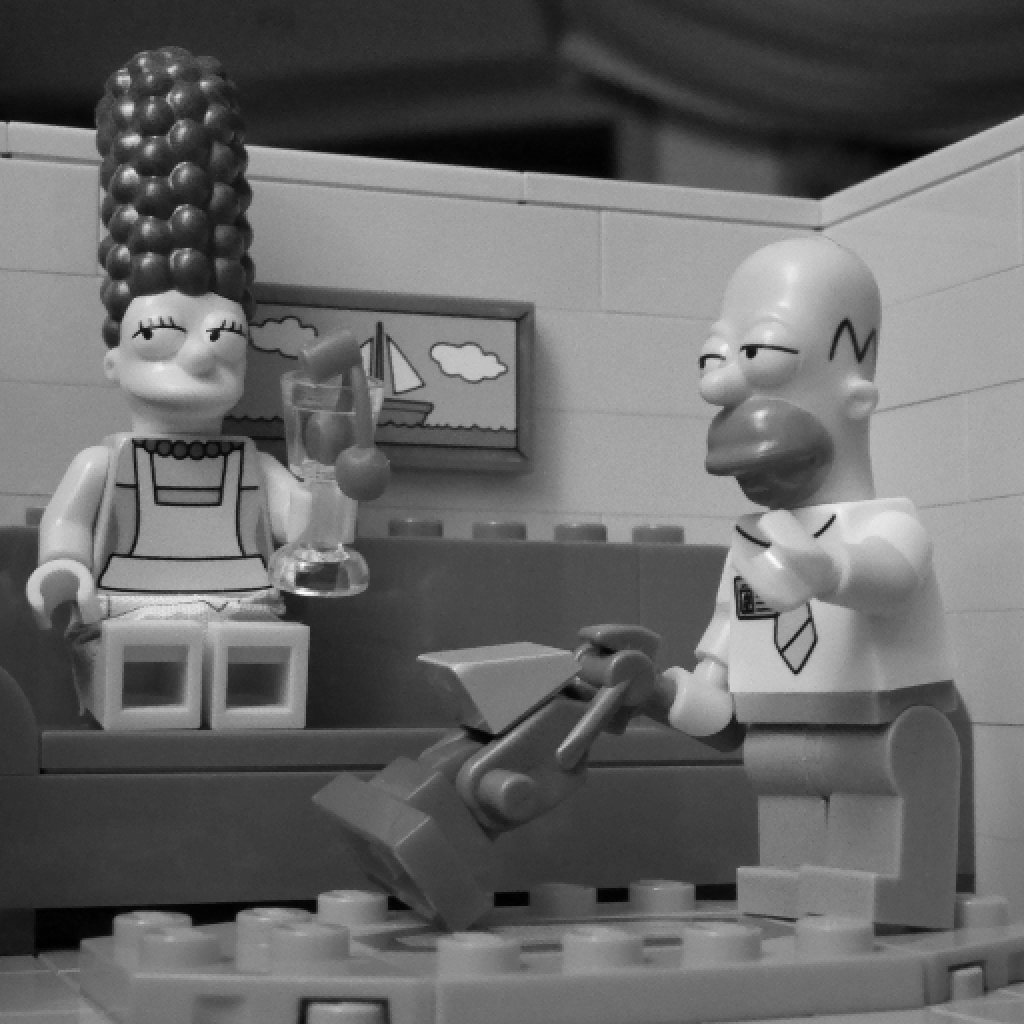

In [2]:
# Open the image
u0 = torch.tensor(rgb2gray(plt.imread('im/simpson512.png')))
M,N = u0.shape

viewimage(u0)

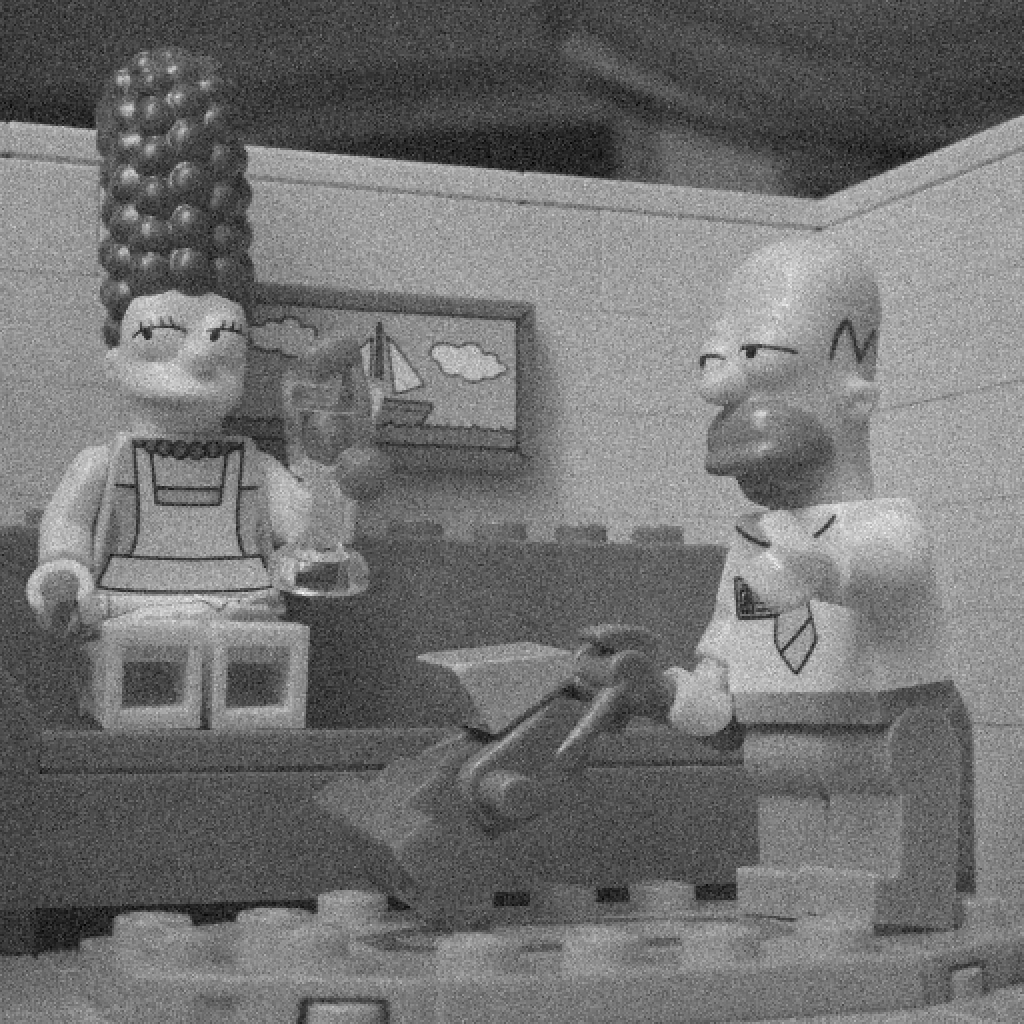

In [3]:
sigma = 15/255
z = u0 + sigma*torch.randn((M, N))

viewimage(z)

In [49]:
x0 = torch.randn((M, N))
p0 = torch.randn((M, N, 2))
lamb = 0.15
xhat, variances = ulpda(z, x0, p0, sigma, lamb, s_k=30, tau_k=1e-3, theta_k=1, K=3000, burnin=1000)

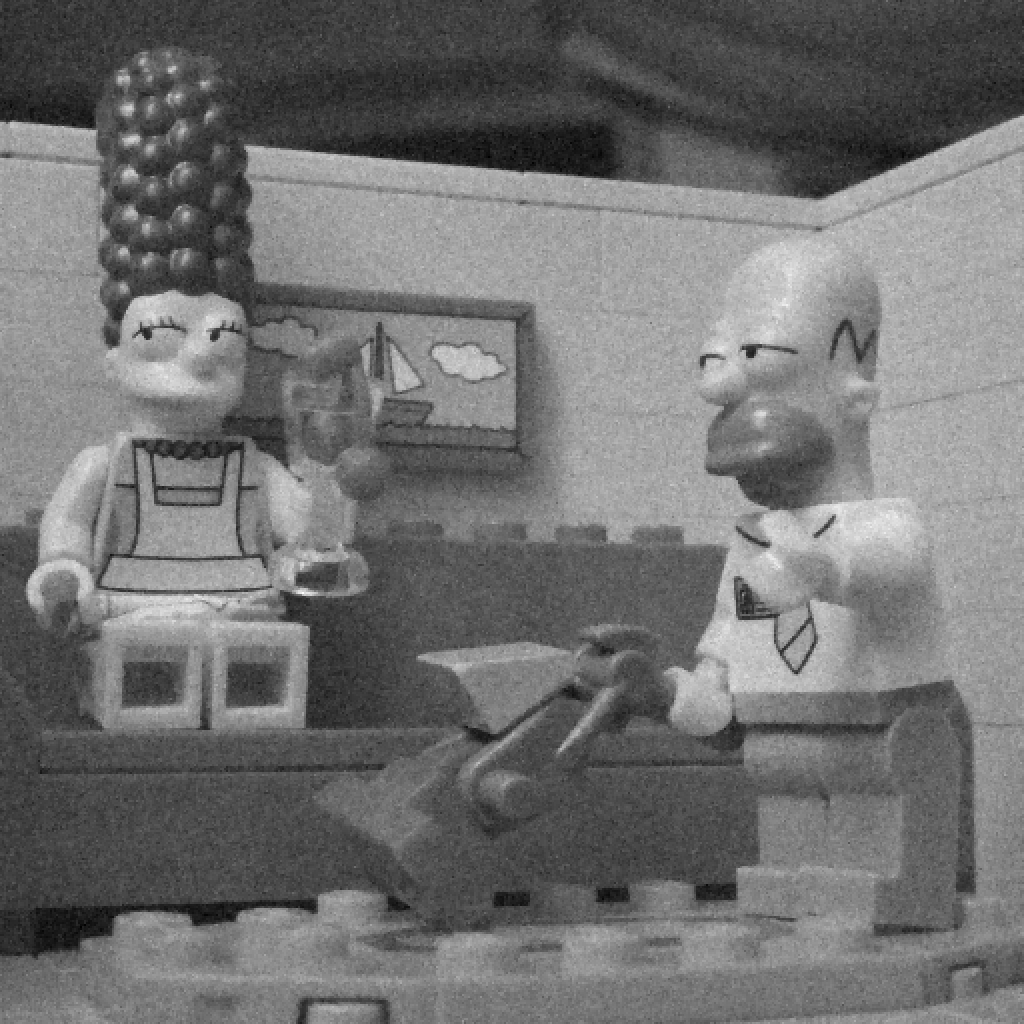

In [50]:
viewimage(xhat)

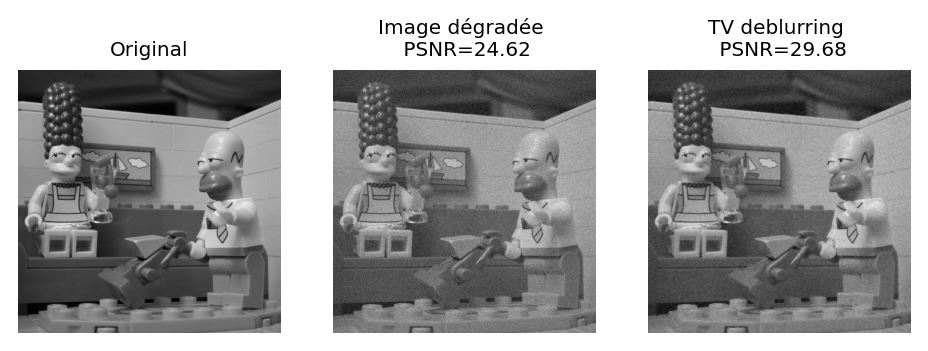

In [51]:
plt.figure(dpi=180)
plt.subplot(1,3,1)
plt.imshow(u0, cmap='gray')
plt.title('Original',fontsize=8)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(z, cmap='gray')
plt.title('Image dégradée \n PSNR='+str2(psnr(u0,z)),fontsize=8)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(xhat, cmap='gray')
plt.title('TV deblurring \n PSNR='+str2(psnr(u0,xhat)),fontsize=8)
plt.axis('off')
plt.show()

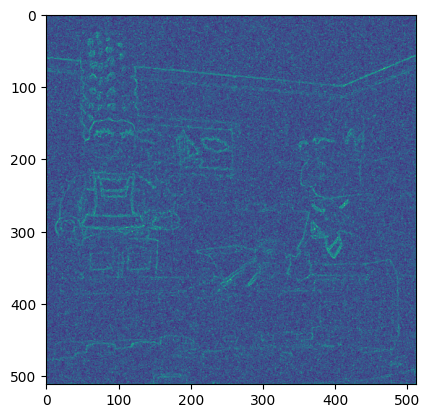

(array([1.5600e+02, 2.1600e+03, 1.3874e+04, 4.0974e+04, 6.4682e+04,
        6.1834e+04, 3.9932e+04, 2.0333e+04, 9.6440e+03, 4.5620e+03,
        2.1020e+03, 1.0020e+03, 4.9600e+02, 2.1000e+02, 9.5000e+01,
        5.1000e+01, 2.4000e+01, 5.0000e+00, 6.0000e+00, 2.0000e+00]),
 array([0.00290946, 0.00305209, 0.00319471, 0.00333733, 0.00347996,
        0.00362258, 0.0037652 , 0.00390783, 0.00405045, 0.00419307,
        0.0043357 , 0.00447832, 0.00462094, 0.00476357, 0.00490619,
        0.00504881, 0.00519143, 0.00533406, 0.00547668, 0.0056193 ,
        0.00576193]),
 <BarContainer object of 20 artists>)

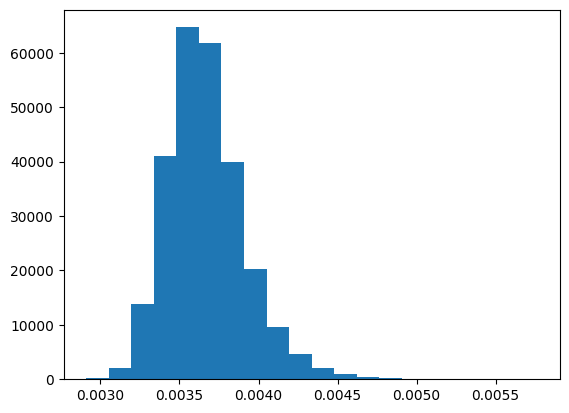

In [52]:
plt.imshow(variances)
plt.show()
plt.hist(variances.flatten(), bins=20)

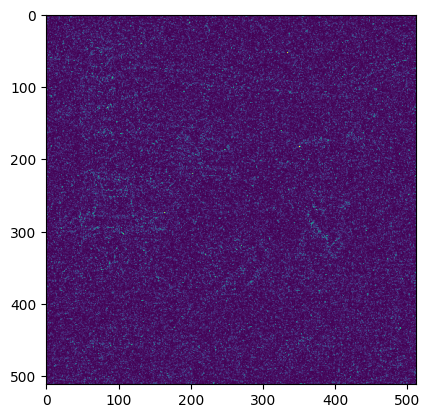

In [40]:
errors = (xhat-u0)**2
plt.imshow(errors, vmin=0, vmax=0.02)

In [41]:
nbins = 100
var_max = .01
bin_step = var_max/nbins
errors_per_bin = [[] for _ in range(nbins)]
for i in range(M):
    for j in range(N):
        bin = min(nbins-1, int(variances[i, j]/bin_step))
        errors_per_bin[bin].append(errors[i, j])
for bin in range(nbins):
    errors_per_bin[bin].sort()

In [42]:
print(list(map(len, errors_per_bin)))

[0, 0, 0, 0, 0, 0, 0, 0, 6, 85, 429, 1608, 4215, 8168, 13479, 18774, 23114, 25573, 26049, 25341, 22422, 19705, 16329, 13248, 10518, 8242, 6150, 4777, 3642, 2684, 1946, 1451, 1087, 793, 624, 437, 325, 260, 173, 129, 104, 64, 48, 38, 33, 22, 14, 11, 6, 7, 1, 2, 3, 1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


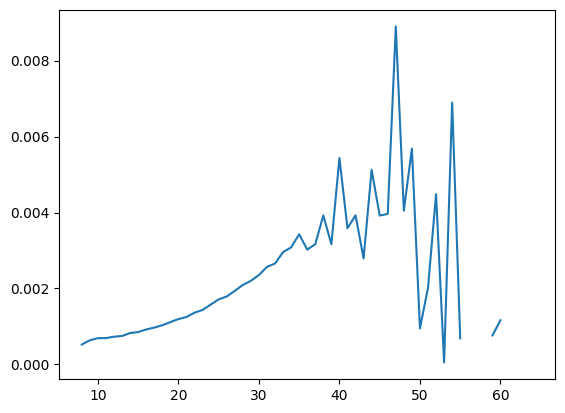

In [43]:
plt.plot(list(map(np.average, errors_per_bin)))

# Training on BSDS dataset

In [53]:
import os

In [54]:
s = []
that = []
sigma = 15/255
lamb = 0.05

for f in tqdm(os.listdir("data/train")):
    if not f.endswith(".png"):
        continue
    u0 = torch.tensor(rgb2gray(plt.imread(os.path.join("data/train", f))))
    M, N = u0.size()
    z = u0 + sigma*torch.randn((M, N))
    x0 = torch.randn((M, N))
    p0 = torch.randn((M, N, 2))
    xhat, variances = ulpda(z, x0, p0, sigma, lamb, s_k=30, tau_k=1e-3, theta_k=1, K=3000, burnin=1000)
    err = (xhat-u0)**2
    s.extend(err.flatten().tolist())
    that.extend(variances.flatten().tolist())

100%|██████████| 201/201 [19:34<00:00,  5.84s/it]


In [63]:
np.save("s.npy", np.array(s))
np.save("that.npy", np.array(that))

In [55]:
np.min(that), np.min(s)

(0.0008494299836456776, 0.0)

/tmp/ipykernel_20089/2658126556.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(hist.T), origin='lower', extent=(that_edges[0], that_edges[-1], s_edges[0], s_edges[-1]), aspect="auto")


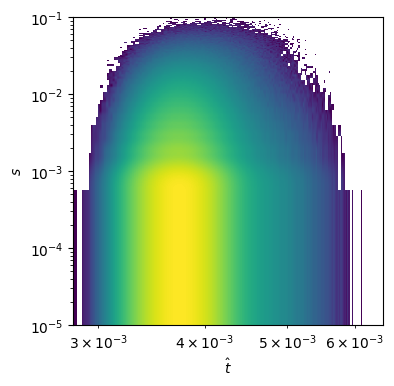

In [73]:
hist, that_edges, s_edges = np.histogram2d(that, s, bins=200)
plt.figure(figsize=(4, 4))
plt.imshow(np.log10(hist.T), origin='lower', extent=(that_edges[0], that_edges[-1], s_edges[0], s_edges[-1]), aspect="auto")
plt.xscale("log")
plt.xlabel("$\\hat{t}$")
plt.yscale("log")
plt.ylabel("$s$")
plt.ylim(1e-5, 1e-1)
plt.show()

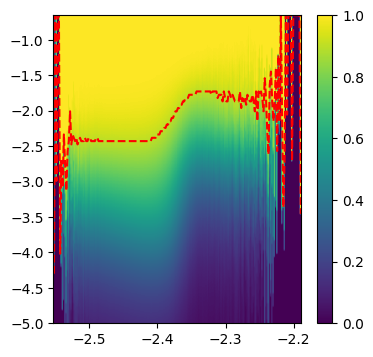

In [65]:
hist, that_edges, s_edges = np.histogram2d(np.log10(that), np.log10(np.array(s)+1e-10), bins=200)
cumhist = np.cumsum(hist, axis=1)
cumhist /= np.where(cumhist[:, -1, None] == 0.0, 1.0, cumhist[:, -1, None])
quantiles = np.zeros(len(that_edges)-1)
for i in range(len(that_edges)-1):
    quantiles[i] = s_edges[np.searchsorted(cumhist[i], .9)]
plt.figure(figsize=(4, 4))
plt.imshow(cumhist.T, origin="lower", extent=(that_edges[0], that_edges[-1], s_edges[0], s_edges[-1]), aspect="auto")
plt.colorbar()
plt.xlim(that_edges[0], that_edges[-1])
plt.ylim(-5.0, s_edges[-1])
plt.plot((that_edges[:-1] + that_edges[1:])/2, quantiles, color='red', linestyle="dashed")
plt.show()

In [56]:
nbins = 100
var_min = np.min(that)
var_max = np.max(that)
bin_step = (var_max-var_min)/nbins
errors_per_bin = [[] for _ in range(nbins)]
for i in range(len(that)):
    bin = min(nbins-1, int((that[i]-var_min)/bin_step))
    errors_per_bin[bin].append(s[i])
for bin in range(nbins):
    errors_per_bin[bin].sort()
print(list(map(len, errors_per_bin)))

[2, 2, 12, 35, 144, 349, 920, 2186, 5177, 11232, 22614, 43735, 78969, 136827, 222052, 342961, 505989, 709108, 950044, 1214123, 1494195, 1756133, 1982711, 2155019, 2250429, 2272394, 2211250, 2081098, 1896251, 1672092, 1431428, 1196013, 971285, 770200, 600174, 458389, 345776, 256769, 190764, 141480, 105465, 79014, 59700, 45955, 36161, 28425, 23287, 19095, 15547, 12977, 10911, 9153, 8079, 6774, 5879, 5010, 4330, 3645, 3246, 2790, 2402, 2054, 1711, 1495, 1248, 1045, 850, 715, 567, 436, 411, 309, 265, 201, 161, 137, 111, 71, 55, 44, 44, 27, 19, 16, 7, 7, 4, 3, 3, 1, 4, 1, 0, 0, 1, 0, 0, 0, 0, 1]


# Testing on images

In [74]:
import math

def test_image(path):
    u0 = torch.tensor(rgb2gray(plt.imread(path)))
    M, N = u0.size()
    z = u0 + sigma*torch.randn((M, N))
    xhat, variances = ulpda(z, torch.randn((M, N)), torch.randn((M, N, 2)), sigma, lamb, s_k=30, tau_k=1e-3, theta_k=1, K=3000, burnin=1000)
    estimated_errors = torch.zeros_like(xhat)
    for i in range(M):
        for j in range(N):
            bin = max(0, min(nbins-1, int((variances[i, j]-var_min)/bin_step)))
            quantile = math.ceil(.9*(1+1/len(errors_per_bin[bin]))*len(errors_per_bin[bin]))-1
            quantile = min(len(errors_per_bin[bin])-1, max(0, quantile))
            estimated_errors[i, j] = errors_per_bin[bin][quantile]

    errors = (xhat - u0)**2
    
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 5, 1)
    plt.imshow(u0, cmap="gray")
    plt.title("Ground truth")
    plt.subplot(1, 5, 2)
    plt.imshow(z, cmap="gray")
    plt.title("Corrupted image")
    plt.subplot(1, 5, 3)
    plt.imshow(xhat, cmap="gray")
    plt.title("MMSE estimator")
    plt.subplot(1, 5, 4)
    plt.imshow((xhat - u0)**2, vmin=0, vmax=0.02)
    plt.title("Error")
    plt.subplot(1, 5, 5)
    plt.imshow(estimated_errors, vmin=0, vmax=0.02)
    plt.title("Estimated error")
    plt.show()

    viewimage(u0)
    viewimage(z)

    coverage = torch.sum(errors <= estimated_errors)/torch.numel(errors)
    print(f"Coverage: {coverage}")

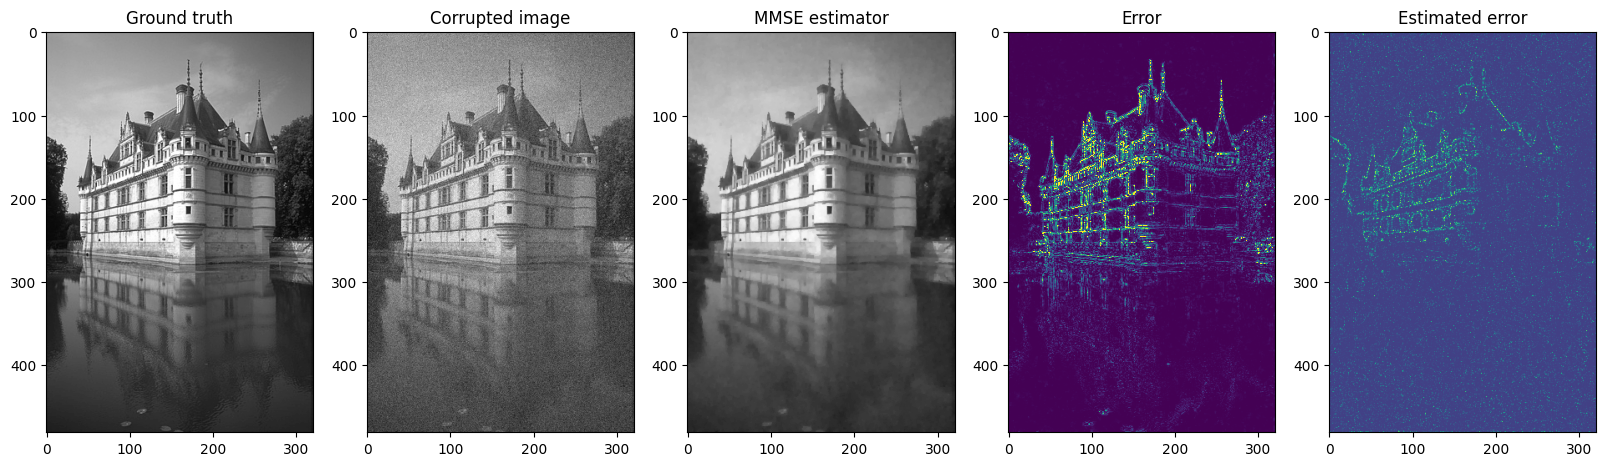

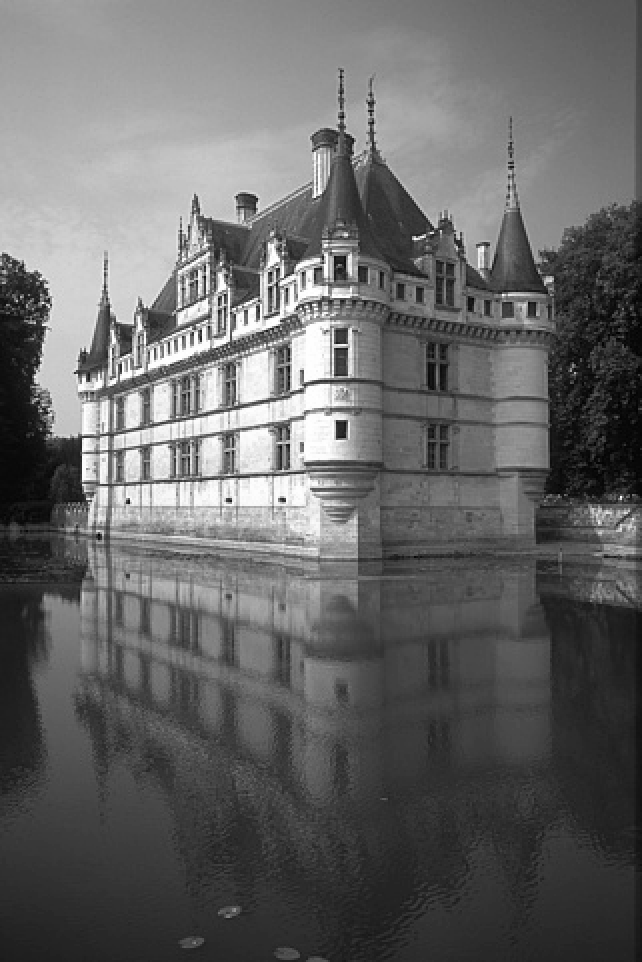

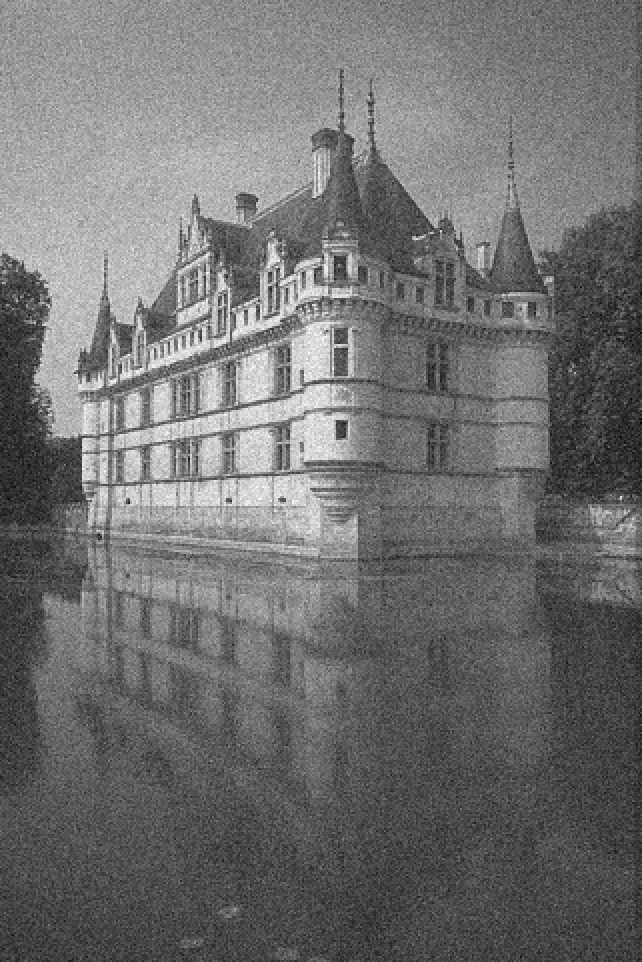

Coverage: 0.9239059090614319


In [75]:
test_image("data/test/102061.png")